# Discrete prolate spheroidal sequences

The discrete prolate spheroidal sequences (Slepian, 1978), $v_n^{(k)}(N,W)$, are the eigenvector solutions to the eigenvalue problem

$$\sum_{m = 0}^{N-1}\frac{\sin 2\pi W(n-m)}{\pi(n-m)}v_m^{(k)}(N,W) = \lambda_k(N,W)\cdot v_n^{(k)}(N,W)$$

where $N$ is the length of the sequence, $n = 0, \ldots, N-1$, $W$ is the bandwidth, $K$ is the number of tapers, and $\lambda_k(N,W)$ is the eigenvalue corresponding to the $k$th taper. 

The dpss's solve the problem of concentrating, in frequency, the most amount of mass under the interval $(-W,W)$, while having only finite extent in time. 

In Multitaper.jl, the dpss's are computed in the following way.

In [ ]:
using Plots, Multitaper, FFTW

N     = 1024
NW    = 4.0 
K     = 8
v,lam = Multitaper.dpss_tapers(N, NW, K, :both)

plot(-512:511, v, label = lam', xlabel = "Index", title = "DPSS's sorted by concentration")

The very first dpss taper has the largest "concentration" in the bandwidth of interest, very close to one. Subsequent tapers are less and less concentrated. To see this, plot their Fourier transforms as below. We zero pad, as before, to interpolate structure in frequency.

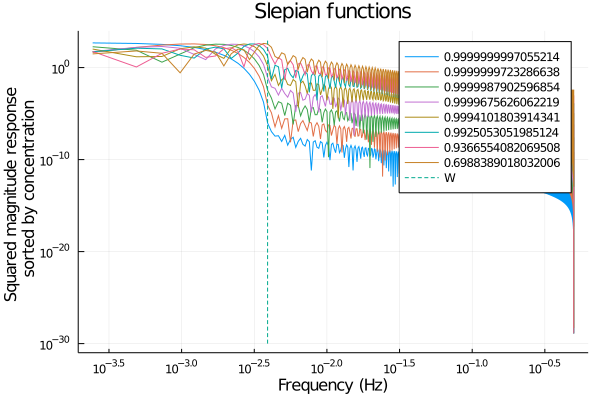

In [2]:
M        = 4*N
U        = mapreduce(x -> fft(vcat(x,zeros(M-N))), hcat, v[:,k] for k in 1:K)
halffreq = Int64(M/2+1)
freq     = range(0, 1,length = M+1)[1:halffreq]

plot(freq[2:end], abs2.(U)[2:halffreq,:], 
    label = lam', yscale = :log10, xscale = :log10,
    xlabel = "Frequency (Hz)", 
    title = "Slepian functions",
    ylabel = "Squared magnitude response \n sorted by concentration")

plot!((NW/N)*ones(2), [1e-30, 1e3], label="W", line = :dash)

One can see that the bulk of the mass under each of the curves is on the interval (-W,W). 
It is also easy to see that as the concentration, lambda, decreases, there is less mass under
the curve inside the band. Since the sequences all have unit energy, there is more mass outside
the band for larger index. Comparing with the tapers in the first plot, we see the power drop off rather quickly outside the band (-W, W) of interest. 

The bandwidth, $W$, is a tuning parameter for the multitaper method, and one adjusts the bandwidth by selecting the time-bandwidth product <tt>NW</tt> above. The number of tapers, $K$, is selected to be less than $2NW$, as the concentration rapidly drops with increasing $k$. For further reading, consult the original paper cited below. 

# 2D Concentration in the Cartesian Plane

For two dimensional sequences where data exist on a Cartesian rectangle, and one wants the spectrum concentrated in a circle one can use the following. The below computes and plots the first three tapers. See Simons and Wang, 2011 for computational details. 

In [3]:
nslep = 3 # Number of Slepian tapers desired
n = 128 # Number of samples in x on the interval [-1,1]
m = 128 # Number of samples in y on the interval [-1,1]
Kp = 12.0 # squared radius of the circle
N = 32 # number of quadrature nodes (keep this small for best performance)
M = 32 # number of quadrature nodes in y-direction
verbose = true

# It takes 248 seconds on a 2.9 GHz 6-core Intel Core i9 processor with 32 GB of 2400 MHz DDR4 memory
# to compute the first 6 tapers
@time R = Multitaper.rectsleps(nslep, n, m, Kp, N, M; verbose=verbose)

The 3 concentrations:
0.9999999940054248
0.9999997895671868
0.9999997895671859
200.841771 seconds (156.68 M allocations: 399.415 GiB, 32.91% gc time)


3-element Array{Array{Float64,2},1}:
 [-2.3825050291978444e-6 -2.496940432943656e-6 … -2.4969404311548944e-6 -2.3825050220774072e-6; -2.4969404328905907e-6 -2.5735867301164905e-6 … -2.5735867318295037e-6 -2.4969404294647447e-6; … ; -2.4969404309245814e-6 -2.5735867317252737e-6 … -2.5735867139764424e-6 -2.496940409929127e-6; -2.382505021740236e-6 -2.496940429258934e-6 … -2.4969404099001433e-6 -2.3825049993486367e-6]
 [-7.74098665766932e-6 -5.973215453373919e-6 … -3.6702461854127156e-7 7.620308462647316e-8; -5.9816000061205614e-6 -4.208631901475983e-6 … 4.1430234400219543e-8 4.8470909710912e-7; … ; -4.847090295470408e-7 -4.1430160606669646e-8 … 4.2086318510303715e-6 5.981599961598644e-6; -7.620302476767553e-8 3.670246861021953e-7 … 5.973215408852629e-6 7.740986620198418e-6]
 [7.620305483398988e-8 4.84709063563361e-7 … 5.981599982047629e-6 7.740986637006662e-6; -3.670246521848689e-7 4.143019773153124e-8 … 4.208631874569775e-6 5.973215429286514e-6; … ; -5.973215430934428e-6 -4.208631876275

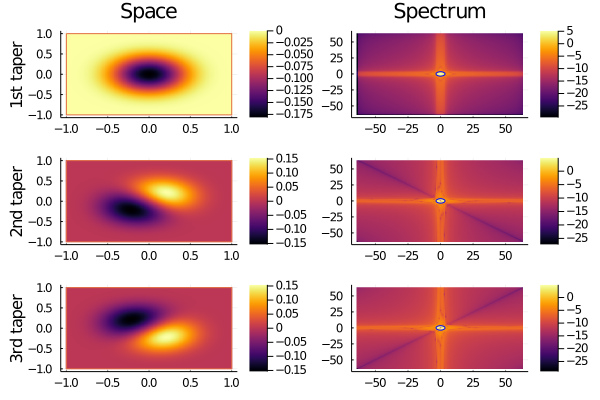

In [4]:
# Regions of concentration in space and spectrum 
xy = hcat(collect(range(-1,1,length=20)),ones(20))
xy = vcat(xy,hcat(ones(20),collect(range(1,-1,length=20))))
xy = vcat(xy,hcat(collect(range(-1,1,length=20)),-ones(20)))
xy = vcat(xy,hcat(-ones(20),collect(range(-1,1,length=20))))

t = range(0,2*pi,length=80)
x = sqrt(12.0)*cos.(t)
y = sqrt(12.0)*sin.(t)

circ = map(y->abs2.(fftshift(fft(R[y]))),1:nslep)

n2 = Int64(n/2)
m2 = Int64(m/2)

q1 = heatmap(range(-1,1,length=128),range(-1,1,length=128),R[1],title="Space",ylabel="1st taper")
q1 = plot!(xy[:,1],xy[:,2],legend=false)
q2 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[1]),title="Spectrum")
q2 = plot!(x,y,c=:blue,legend=false)

q3 = heatmap(range(-1,1,length = 128),range(-1,1,length=128),R[2],ylabel="2nd taper")
q3 = plot!(xy[:,1],xy[:,2],legend=false)
q4 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[2]))
q4 = plot!(x,y,c=:blue,legend=false)

q5 = heatmap(range(-1,1,length=128),range(-1,1,length=128),R[3],ylabel="3rd taper")
q5 = plot!(xy[:,1],xy[:,2],legend=false)
q6 = heatmap(collect(-n2:(n2-1)),collect(-m2:(m2-1)),log10.(circ[3]))
q6 = plot!(x,y,c=:blue,legend=false)

plot(q1, q2, q3, q4, q5, q6, layout=(3,2))

# References

Simons, Frederik J., and Dong V. Wang. "Spatiospectral concentration in the Cartesian plane." GEM-International Journal on Geomathematics 2.1 (2011): 1-36.

Slepian, David. "Prolate spheroidal wave functions, Fourier analysis, and uncertainty—V: The discrete case." Bell System Technical Journal 57.5 (1978): 1371-1430.